In [1]:
from epymorph.parameter_fitting.filters.particle_filter import ParticleFilter
from epymorph.parameter_fitting.likelihoods.poisson import PoissonLikelihood
from epymorph.parameter_fitting.particlefilter_simulation import FilterSimulation
from epymorph.parameter_fitting.utils import plots
from epymorph.parameter_fitting.utils.observations import Observations
from epymorph.parameter_fitting.utils.ParameterEstimation import EstimateParameters

from epymorph.parameter_fitting.dynamics.dynamics import GeometricBrownianMotion
import scipy
from epymorph.adrio import acs5, csv


In [2]:
from epymorph.data_shape import Shapes
from epymorph.initializer import Initializer
from epymorph.simulation import AttributeDef

import numpy as np


class PFInitializer(Initializer):
    requirements = [AttributeDef("population", int, Shapes.N)]

    def __init__(self, index2=0, index3=0, index4=0) -> None:
        self.index2 = index2
        self.index3 = index3
        self.index4 = index4

    def evaluate(self):
        total_population = self.data("population")[0]  # 7_174_064
        # initial_particle cloud
        initializer = np.array(
            [
                [
                    total_population - self.index2 - self.index3 - self.index4,
                    self.index2,
                    self.index3,
                    self.index4,
                ]
            ],
            dtype=np.int64,
        )
        return initializer

In [3]:
# ruff: noqa: F405
from epymorph import *  # noqa: F403
from epymorph.geography.us_census import StateScope
from epymorph.data.ipm.sirh import Sirh
from epymorph.data.mm.no import No


rume = SingleStrataRume.build(
    # Load an IPM from the library
    ipm=Sirh(),
    # Load an MM from the library
    mm=No(),
    # Use our scope
    scope=StateScope.in_states(["AZ"], year=2015),
    # Create a SingleLocation initializer
    # Provide an initializer of your coice or create a custom initializer as
    # above and pass it
    init=PFInitializer(50, 1434813, 23),
    # Set the time-frame to simulate
    time_frame=TimeFrame.of("2022-10-01", 371),
    # Provide parameter values
    params={
        # "beta": To be estimated,
        "gamma": 0.25,
        "xi": 1 / 365,  # 0.0111,
        "hospitalization_prob": 0.03,
        "hospitalization_duration": 5.0,
        # Geographic data can be loaded using ADRIOs
        "population": acs5.Population(),
    },
)

In [4]:
[e.name.full for e in rume.ipm.events]

['S → I', 'I → H', 'I → R', 'H → R', 'R → S']

In [5]:
likelihood_fn = PoissonLikelihood()
filter_type = ParticleFilter(num_particles=250)

In [6]:
from pathlib import Path

csvadrio = csv.CSVTimeSeries(
    file_path=Path(
        "C:/Users/sm4335/OneDrive - Northern Arizona University/Pictures/Screenshots/influenza.csv"
    ),
    time_col=0,
    time_frame=TimeFrame.range("2022-10-01", "2023-09-30"),
    key_col=1,
    data_col=2,
    data_type=int,
    key_type="geoid",
    skiprows=1,
)

In [7]:
# observations = Observations(
#     InfluenzaHospitalizationSumState(rume.time_frame),
#     model_link="I → H",
# )

observations = Observations(
    csvadrio,
    model_link="I → H",
)


In [8]:
params_space = {
    "beta": EstimateParameters.TimeVarying(
        distribution=scipy.stats.uniform(loc=0.1, scale=0.7),
        dynamics=GeometricBrownianMotion(volatility=0.1),
    )
}

In [9]:
sim = FilterSimulation(
    rume=rume,
    observations=observations,
    likelihood_fn=likelihood_fn,
    filter_type=filter_type,
    params_space=params_space,
)

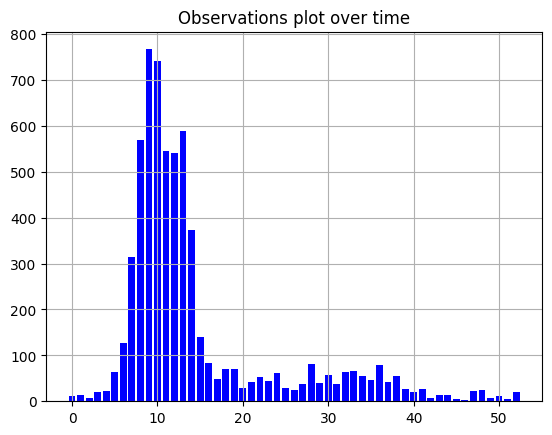

In [10]:
sim.plot_data()

In [11]:
output = sim.run()

 15%|█▌        | 8/53 [00:12<01:14,  1.66s/it]

Error: underflow encountered in exp. model data = 315 true data = 1557
Error: underflow encountered in exp. model data = 315 true data = 1576
Error: underflow encountered in exp. model data = 315 true data = 1542
Error: underflow encountered in exp. model data = 315 true data = 1573
Error: underflow encountered in exp. model data = 315 true data = 1563


 17%|█▋        | 9/53 [00:13<01:12,  1.64s/it]

Error: underflow encountered in exp. model data = 569 true data = 3603
Error: underflow encountered in exp. model data = 569 true data = 3350


 19%|█▉        | 10/53 [00:15<01:13,  1.70s/it]

Error: underflow encountered in exp. model data = 767 true data = 2762
Error: underflow encountered in exp. model data = 767 true data = 2747
Error: underflow encountered in exp. model data = 767 true data = 2695


 26%|██▋       | 14/53 [00:22<01:07,  1.72s/it]

Error: underflow encountered in exp. model data = 590 true data = 2558
Error: underflow encountered in exp. model data = 590 true data = 2564
Error: underflow encountered in exp. model data = 590 true data = 2507
Error: underflow encountered in exp. model data = 590 true data = 2458
Error: underflow encountered in exp. model data = 590 true data = 2500
Error: underflow encountered in exp. model data = 590 true data = 2503
Error: underflow encountered in exp. model data = 590 true data = 2638
Error: underflow encountered in exp. model data = 590 true data = 2530


 28%|██▊       | 15/53 [00:24<01:06,  1.75s/it]

Error: underflow encountered in exp. model data = 374 true data = 1672


 94%|█████████▍| 50/53 [02:17<00:18,  6.09s/it]

Error: underflow encountered in exp. model data = 8 true data = 753
Error: underflow encountered in exp. model data = 8 true data = 772
Error: underflow encountered in exp. model data = 8 true data = 796


100%|██████████| 53/53 [02:36<00:00,  2.96s/it]


In [13]:
output

ParticleFilterOutput(num_particles=250, duration='371 days ', param_quantiles={'beta': [[0.10886296998836703, 0.14646090736920275, 0.17074556944448052, 0.2031654045684243, 0.23432590466480804, 0.2724036834273042, 0.31633216231940187, 0.35542061552755755, 0.3721935063922604, 0.4213829144346948, 0.4652908420803019, 0.48128215594308343, 0.5082304105798027, 0.5478329929930883, 0.5821747518232231, 0.6204973789603218, 0.6427087554533086, 0.7041400598004478, 0.7113920706631665, 0.7291237200869874, 0.7577865553035572, 0.7753077393383617, 0.7792579472573382], [0.35232543963633317, 0.3649672554804468, 0.40489602082527726, 0.49986369795177654, 0.5444349982148223, 0.5444349982148223, 0.5505098791573834, 0.5884877654259242, 0.59322650588045, 0.6250800101681478, 0.6441478757519412, 0.6888387943334355, 0.7193236362211535, 0.7596364190564325, 0.8543231203959071, 0.8543231203959071, 0.9741410932509491, 0.9823668784334842, 1.0178312220486727, 1.1937837614528752, 1.2531826380066793, 1.7812398154495142, 1

In [14]:
print(output)

Particle Filter Output
-----------------------
Number of Particles: 250
Duration: 371 days 

Parameter Quantiles (Showcasing a few values):
beta:   0.109, 0.146, 0.171, 0.203, 0.234, 0.272, 0.316, 0.355, 0.372, 0.421, 0.465, 0.481, 0.508, 0.548, 0.582, 0.620, 0.643, 0.704, 0.711, 0.729, 0.758, 0.775, 0.779
  0.352, 0.365, 0.405, 0.500, 0.544, 0.544, 0.551, 0.588, 0.593, 0.625, 0.644, 0.689, 0.719, 0.760, 0.854, 0.854, 0.974, 0.982, 1.018, 1.194, 1.253, 1.781, 1.781

Parameter Values (Showcasing a few values):
beta: 0.478, 0.778, 0.400

True Data:
  12.000
  14.000
  7.000
  21.000
  23.000

Model Data:
  50.000
  4.236
  84.260
  17.852
  47.356


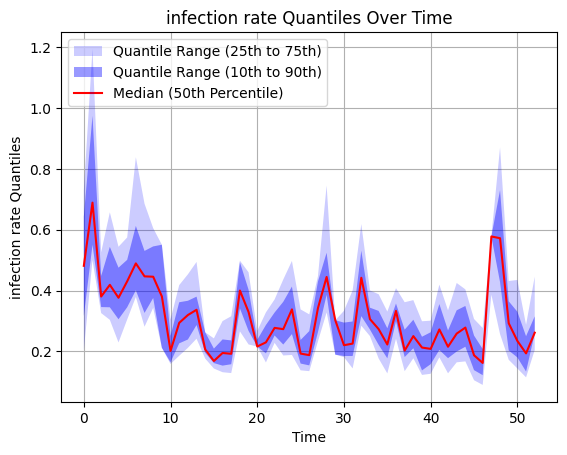

In [15]:
plots.params_plot(output=output, parameter="infection rate")

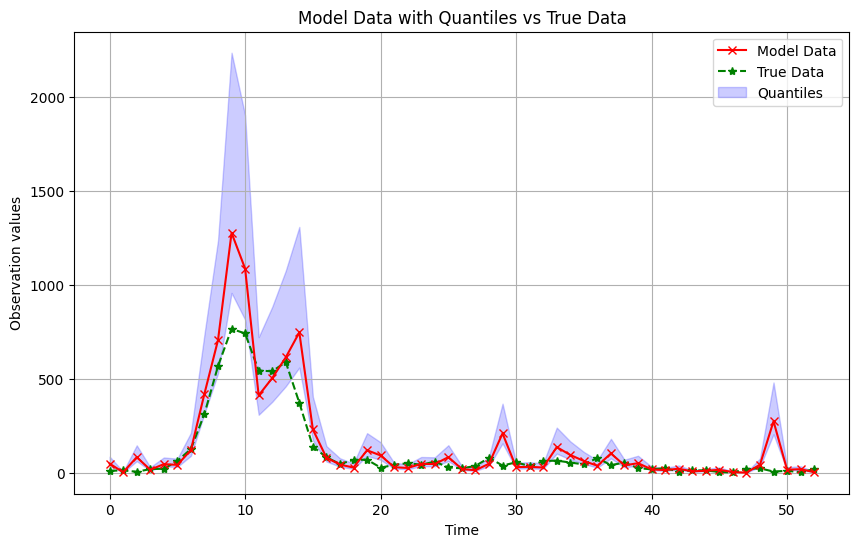

In [16]:
plots.model_fit(output=output)